# MNIST SGD

In [1]:
from fastai2.vision.all import *
from utils import *
matplotlib.rc('image', cmap='Blues')

## Load Images

In [2]:
im_path = untar_data(URLs.MNIST)

In [3]:
im_path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [4]:
(im_path/"training").ls()

(#10) [Path('/storage/data/mnist_png/training/0'),Path('/storage/data/mnist_png/training/2'),Path('/storage/data/mnist_png/training/9'),Path('/storage/data/mnist_png/training/8'),Path('/storage/data/mnist_png/training/7'),Path('/storage/data/mnist_png/training/1'),Path('/storage/data/mnist_png/training/5'),Path('/storage/data/mnist_png/training/4'),Path('/storage/data/mnist_png/training/6'),Path('/storage/data/mnist_png/training/3')]

In [5]:
(im_path/"training"/"3").ls()

(#6131) [Path('/storage/data/mnist_png/training/3/26208.png'),Path('/storage/data/mnist_png/training/3/12882.png'),Path('/storage/data/mnist_png/training/3/58219.png'),Path('/storage/data/mnist_png/training/3/13242.png'),Path('/storage/data/mnist_png/training/3/53225.png'),Path('/storage/data/mnist_png/training/3/51947.png'),Path('/storage/data/mnist_png/training/3/57974.png'),Path('/storage/data/mnist_png/training/3/9812.png'),Path('/storage/data/mnist_png/training/3/6658.png'),Path('/storage/data/mnist_png/training/3/11285.png')...]

In [6]:
def load_images(p):
    return torch.stack([tensor(Image.open(im)).float()/255 for im in p.ls()])

In [7]:
## Load training images
train_3s = load_images(im_path/"training"/"3")
train_8s = load_images(im_path/"training"/"8")
train_3s.shape, train_8s.shape

(torch.Size([6131, 28, 28]), torch.Size([5851, 28, 28]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff34379ffd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff343206350>)

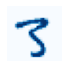

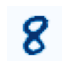

In [8]:
show_image(train_3s[0]), show_image(train_8s[0])

In [9]:
## Load validation images
valid_3s = load_images(im_path/"testing"/"3")
valid_8s = load_images(im_path/"testing"/"8")
valid_3s.shape, valid_8s.shape

(torch.Size([1010, 28, 28]), torch.Size([974, 28, 28]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff343201b10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff34311af90>)

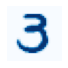

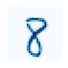

In [10]:
show_image(valid_3s[0]), show_image(valid_8s[0])

## Loss Function

For the model, we use a simple function like this:

```
pred = weights * pixels + bias
```

Basically, we assign a weight for each pixel. So, we can arrange all the pixels into a single row.

In [11]:
train_x = torch.cat([train_3s, train_8s]).view(-1, 28 * 28)
train_x.shape

torch.Size([11982, 784])

**Basically, now a single row is an image**

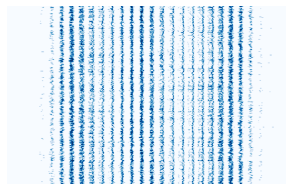

In [12]:
## How 3s looks alike
show_image(train_x[1:500,])

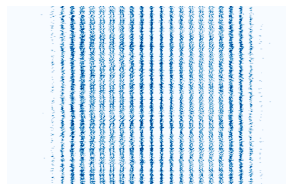

In [13]:
## How 8s looks like
show_image(train_x[-500:-1,])

**GOAL:** Find a way to differentiate these two 

In [14]:
train_y = tensor([1] * len(train_3s) + [0] * len(train_8s)).unsqueeze(1)
train_y.shape

torch.Size([11982, 1])

In [15]:
valid_x = torch.cat([valid_3s, valid_8s]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3s) + [0] * len(valid_8s))

In [16]:
def mnist_model(X, weights, bias):
    return X@weights + bias

In [17]:
def init_params(shape):
    return torch.randn(shape).requires_grad_()

In [18]:
weights = init_params((train_x.shape[1], 1))
bias = init_params(1)        

In [19]:
preds = mnist_model(train_x, weights, bias)
preds.shape

torch.Size([11982, 1])

In [20]:
## Accuracy function
# Here we are defining the model value > 0 as 3s and others and others ans 8s.
# (This is also our loss function)
def accuracy(preds, Y):
    pred_trues = (preds > 0).float() == Y
    return pred_trues.float().mean()

In [21]:
# So, we got an accuracy of 50%
loss = accuracy(preds, train_y)
loss.item()

0.5599232316017151

In [22]:
# Now let's change the weights a bit
weights[0] *= 0.001

In [23]:
# Let's run the model again and find the loss
preds = mnist_model(train_x, weights, bias)
loss2 = accuracy(preds, train_y)
loss2.item()

0.5599232316017151

**As you can see, there's no change in our loss. So, we cannot measure the improvements of our weights using a loss function like accuracy. For that, we need something else.**

For that, we can use the abs mean error

In [24]:
## Our targets are between 0 and 1, but our preds
torch.min(preds), torch.max(preds)

(tensor(-36.1528, grad_fn=<MinBackward1>),
 tensor(21.0948, grad_fn=<MaxBackward1>))

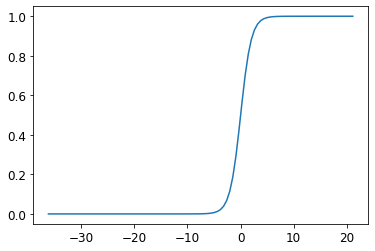

In [25]:
## So, we need some function to transform these preds into a range of 0 and 1. Luckily we have something. Sigmoid
plot_function(torch.sigmoid, min=torch.min(preds).item(), max=torch.max(preds).item())

In [26]:
def mnist_loss(preds, Y):
    return (torch.sigmoid(preds) - Y).abs().mean()

In [27]:
weights = init_params(28*28)
bias = init_params(1)     

In [28]:
preds = mnist_model(train_x, weights, bias)
loss = mnist_loss(preds, train_y)
print(f'Loss: {loss.item()}')
loss.backward()

Loss: 0.49173566699028015


In [29]:
def update_params(p, lr=1e-5):
    p.data -= p.grad * lr
    p.grad.zero_()

In [30]:
update_params(weights)
update_params(bias)

In [31]:
#run again
preds = mnist_model(train_x, weights, bias)
loss = mnist_loss(preds, train_y)
print(f'Loss: {loss.item()}')

Loss: 0.49173566699028015


**See. It's getting smaller.**

Let's put all those together.

## Using GD

In [32]:
def find_accuracy(X, Y):
    W = weights.data.clone();
    B = bias.data.clone();
    P = mnist_model(X, W, B)
    return ((torch.sigmoid(P) > 0.5) == Y).float().mean()

In [33]:
weights = init_params(28*28)
bias = init_params(1)

In [34]:
def run_epoch(lr=1.):
    preds = mnist_model(train_x, weights, bias)
    loss = mnist_loss(preds, train_y)
    loss.backward()
    update_params(weights, lr)
    update_params(bias, lr)
    
    print('ACC:', find_accuracy(valid_x, valid_y))

In [35]:
for i in range(30):
    run_epoch()

ACC: tensor(0.4884)
ACC: tensor(0.4884)
ACC: tensor(0.4884)
ACC: tensor(0.4879)
ACC: tensor(0.4884)
ACC: tensor(0.4889)
ACC: tensor(0.4889)
ACC: tensor(0.4894)
ACC: tensor(0.4894)
ACC: tensor(0.4904)
ACC: tensor(0.4904)
ACC: tensor(0.4909)
ACC: tensor(0.4914)
ACC: tensor(0.4919)
ACC: tensor(0.4919)
ACC: tensor(0.4914)
ACC: tensor(0.4909)
ACC: tensor(0.4909)
ACC: tensor(0.4919)
ACC: tensor(0.4919)
ACC: tensor(0.4919)
ACC: tensor(0.4919)
ACC: tensor(0.4919)
ACC: tensor(0.4924)
ACC: tensor(0.4919)
ACC: tensor(0.4919)
ACC: tensor(0.4919)
ACC: tensor(0.4924)
ACC: tensor(0.4924)
ACC: tensor(0.4924)


## Using SGD

In [63]:
weights = init_params(28*28)
bias = init_params(1)

In [64]:
train_dset = list(zip(train_x, train_y))

In [65]:
train_dl = DataLoader(train_dset, batch_size=256)

In [66]:
X, Y= first(train_dl)
X.shape, Y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [67]:
def run_epoch_sgd(dl, lr=1.):
    for X, Y in dl:
        preds = mnist_model(X, weights, bias)
        loss = mnist_loss(preds, Y)
        loss.backward()
        update_params(weights, lr)
        update_params(bias, lr)
        
    print('ACC', find_accuracy(valid_x, valid_y))

In [73]:
for i in range(30):
    run_epoch_sgd(train_dl, 0.5)

ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9632)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)
ACC tensor(0.9637)


## Using Optimizer + Models


FastAI and PyTorch comes with a lot of techniques + tools. We can reuse some of those.

In [48]:
model = nn.Linear(28 * 28, 1)
model

Linear(in_features=784, out_features=1, bias=True)

In [49]:
W, B = model.parameters()
W.shape, B.shape

(torch.Size([1, 784]), torch.Size([1]))

In [50]:
# Create an optimize to update params
class MyOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data -= p.grad * self.lr
            
    def zero_grad(self):
        for p in self.params:
            p.grad.zero_();

In [51]:
my_opt = MyOptim(model.parameters(), 1.)

In [52]:
## Create validation data loader
valid_dset = list(zip(valid_x, valid_y))
valid_dl = DataLoader(valid_dset, batch_size=225)

In [53]:
def mnist_accuracy(preds, Y):
    return ((torch.sigmoid(preds) > 0.5) == Y).float().mean()

In [54]:
def get_accuracy(model, dl):
    acc_list = tensor([mnist_accuracy(model(X), Y) for X, Y in dl])
    return acc_list.mean()

In [55]:
def run_epoch(model, opt):
    for X, Y in train_dl:
        preds = model(X)
        loss = mnist_loss(preds, Y)
        loss.backward();
        opt.step();
        opt.zero_grad();

In [56]:
def run_model(model, epochs, lr=1.):
    opt = MyOptim(model.parameters(), lr)
    for i in range(epochs):
        run_epoch(model, opt)
        acc = get_accuracy(model, valid_dl)
        print(f'ACC: {acc.item()}')
#         opt.zero_grad();

In [61]:
model = nn.Linear(28 * 28, 1)
run_model(model, 20, lr=.5)

ACC: 0.5012345910072327
ACC: 0.5091138482093811
ACC: 0.5923621654510498
ACC: 0.6756323575973511
ACC: 0.7238189578056335
ACC: 0.7583320140838623
ACC: 0.7824965715408325
ACC: 0.8021948337554932
ACC: 0.8130260705947876
ACC: 0.8243621587753296
ACC: 0.8322304487228394
ACC: 0.8440603613853455
ACC: 0.8509629368782043
ACC: 0.8558902740478516
ACC: 0.8603017926216125
ACC: 0.8661947846412659
ACC: 0.8681480884552002
ACC: 0.8696186542510986
ACC: 0.8715720176696777
ACC: 0.8745349645614624


**It seems like this model is not as what we defined above**<br/>
So, let's create a custom model.

In [113]:
class MyModel(nn.Module):
    def __init__(self, in_features, out_features=1):
        super(MyModel, self).__init__()
        self.weights = torch.randn((in_features, out_features)).requires_grad_()
        self.bias = torch.randn(1).requires_grad_()
        
    def parameters(self):
        return [self.weights, self.bias]
        
    def forward(self, X):
        return X@self.weights + self.bias

In [114]:
my_model = MyModel(28*28)
run_model(my_model, 40, lr=1.)

ACC: 0.498745858669281
ACC: 0.5409939289093018
ACC: 0.5434510111808777
ACC: 0.6120054721832275
ACC: 0.6866495609283447
ACC: 0.7526907324790955
ACC: 0.7881585359573364
ACC: 0.8093162775039673
ACC: 0.825568675994873
ACC: 0.837343692779541
ACC: 0.8477141261100769
ACC: 0.8539798259735107
ACC: 0.8599057793617249
ACC: 0.8661935925483704
ACC: 0.8675649762153625
ACC: 0.869035542011261
ACC: 0.8749175667762756
ACC: 0.8783524036407471
ACC: 0.8817982077598572
ACC: 0.8813043832778931
ACC: 0.8826758861541748
ACC: 0.8841354250907898
ACC: 0.8861106634140015
ACC: 0.8865935802459717
ACC: 0.8870874643325806
ACC: 0.8890736699104309
ACC: 0.8910380601882935
ACC: 0.8930132985115051
ACC: 0.8940010070800781
ACC: 0.8944947719573975
ACC: 0.8949887156486511
ACC: 0.8954824805259705
ACC: 0.8959763050079346
ACC: 0.8959763050079346
ACC: 0.8959652781486511
ACC: 0.8959652781486511
ACC: 0.8964481353759766
ACC: 0.8964481353759766
ACC: 0.8969419002532959
ACC: 0.8969419002532959


### It seems like our model is much better than nn.Linear
That's strange.

## Let's Create a Nueral Network

Basically here we are trying to add some non-linearity to our model.

In [80]:
class MyNNModel(nn.Module):
    def __init__(self, n_features):
        super(MyNNModel, self).__init__();
        self.w1 = torch.randn((n_features, 30)).requires_grad_()
        self.b1 = torch.randn(1).requires_grad_()
        self.w2 = torch.randn(30).requires_grad_()
        self.b2 = torch.randn(1).requires_grad_()
        
    def parameters(self):
        return [self.w1, self.b1, self.w2, self.b2]
    
    def forward(self, X):
        res = X@self.w1 + self.b1
        res = res.max(tensor(0.))
        res = res@self.w2 + self.b2
        
        return res

In [150]:
my_nn_model = MyNNModel(28*28)
run_model(my_nn_model, 40, lr=0.1)

ACC: 0.603711724281311
ACC: 0.6686312556266785
ACC: 0.7098389863967896
ACC: 0.7342565655708313
ACC: 0.7602657079696655
ACC: 0.7776596546173096
ACC: 0.7964251041412354
ACC: 0.8063016533851624
ACC: 0.8171122074127197
ACC: 0.8257273435592651
ACC: 0.8358239531517029
ACC: 0.8424637317657471
ACC: 0.8493773341178894
ACC: 0.8555233478546143
ACC: 0.8577187657356262
ACC: 0.861175537109375
ACC: 0.8664975762367249
ACC: 0.8719297051429749
ACC: 0.8748926520347595
ACC: 0.8772517442703247
ACC: 0.8812023401260376
ACC: 0.8836714625358582
ACC: 0.8866344690322876
ACC: 0.8866344690322876
ACC: 0.888609766960144
ACC: 0.8902012705802917
ACC: 0.8916828632354736
ACC: 0.8941519260406494
ACC: 0.8966209888458252
ACC: 0.8990902304649353
ACC: 0.9010655283927917
ACC: 0.90205317735672
ACC: 0.9005717039108276
ACC: 0.9025470018386841
ACC: 0.9030407667160034
ACC: 0.9045222401618958
ACC: 0.9060038328170776
ACC: 0.9084728956222534
ACC: 0.9104481935501099
ACC: 0.9119296669960022


In [151]:
run_model(my_nn_model, 10, lr=0.1)

ACC: 0.9129173755645752
ACC: 0.9135212302207947
ACC: 0.9136312007904053
ACC: 0.9146189093589783
ACC: 0.9151127338409424
ACC: 0.9146189093589783
ACC: 0.9151127338409424
ACC: 0.9161003828048706
ACC: 0.9161003828048706
ACC: 0.9165942072868347


**Hmm. That's not a that much of an improvment.**
Basically, there's no improvement at all.

In [120]:
class MyRelu(nn.Module):
    def forward(self, X):
        return X.max(tensor(0.0))

In [175]:
## Let's create the model in a different way
def get_nn_model():
    return nn.Sequential(
        nn.Linear(28*28, 30),
        nn.ReLU(),
        nn.Linear(30, 1)
    )

In [177]:
run_model(get_nn_model(), 40, lr=.1)

ACC: 0.691281259059906
ACC: 0.5012345910072327
ACC: 0.5401700735092163
ACC: 0.6588422656059265
ACC: 0.7282742857933044
ACC: 0.7706007957458496
ACC: 0.79524827003479
ACC: 0.8140137195587158
ACC: 0.8282908201217651
ACC: 0.8366529941558838
ACC: 0.8494704961776733
ACC: 0.8583264946937561
ACC: 0.862748920917511
ACC: 0.8656790256500244
ACC: 0.8686200380325317
ACC: 0.8705734014511108
ACC: 0.8735363483428955
ACC: 0.8769822120666504
ACC: 0.879451334476471
ACC: 0.8809217810630798
ACC: 0.8828861713409424
ACC: 0.8838518261909485
ACC: 0.8838518261909485
ACC: 0.8843457102775574
ACC: 0.8858271241188049
ACC: 0.8873085975646973
ACC: 0.8892619609832764
ACC: 0.8902496695518494
ACC: 0.89073246717453
ACC: 0.8922140598297119
ACC: 0.8936954140663147
ACC: 0.8946831226348877
ACC: 0.8956707715988159
ACC: 0.8950669169425964
ACC: 0.8955606818199158
ACC: 0.8965483903884888
ACC: 0.8970421552658081
ACC: 0.8980298638343811
ACC: 0.8985127210617065
ACC: 0.8985127210617065


## Using a Learner

By doing this, we can reuse a lot of stuff coming from fastai.

In [164]:
## Add both dataloaders together
dls = DataLoaders(train_dl, valid_dl)

In [168]:
## Let's create the leaerner
learn = Learner(dls, MyModel(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=mnist_accuracy)

In [169]:
learn.fit(30, lr=.5)

epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.614611,0.500711,0.501579,00:00
1,0.608779,0.496691,0.503069,00:00
2,0.605291,0.494718,0.505096,00:00
3,0.601552,0.492517,0.505600,00:00
4,0.592019,0.472528,0.523958,00:00
5,0.480602,0.396425,0.604324,00:00
6,0.299308,0.380194,0.619556,00:00
7,0.209126,0.306929,0.694971,00:00
8,0.160228,0.252402,0.752789,00:00
9,0.133355,0.213553,0.795016,00:00


As you can see, here we cannot use our defined MyOptim classes because they lack some of the methods and properties needed.

That's why we use stuff comes with fast.ai

```
MyOptim ~= SGD
```

## Use Our NN Model with a Learner

In [170]:
learn = Learner(dls, MyNNModel(28*28), opt_func=SGD, loss_func=mnist_loss, metrics=mnist_accuracy)

In [171]:
learn.fit(40, .1)

epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.374334,0.311380,0.688508,00:01
1,0.258273,0.326495,0.674395,00:00
2,0.205330,0.288688,0.711190,00:00
3,0.174478,0.249385,0.752016,00:00
4,0.159647,0.222399,0.777218,00:00
5,0.148789,0.202422,0.797883,00:00
6,0.142988,0.183755,0.812500,00:00
7,0.136208,0.170698,0.828125,00:00
8,0.129844,0.158964,0.841230,00:00
9,0.124212,0.149450,0.852319,00:00


## Using fine_tune()

In [192]:
learn = Learner(dls, MyNNModel(28*28), loss_func=mnist_loss, opt_func=SGD, metrics=mnist_accuracy)
learn.fine_tune(40, base_lr=0.1)

epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.340201,0.459085,0.541331,00:00


epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.361382,0.447177,0.553427,00:00
1,0.358143,0.433748,0.566028,00:00
2,0.352717,0.410010,0.590726,00:00
3,0.341809,0.384795,0.613407,00:00
4,0.329841,0.356902,0.643649,00:00
5,0.310659,0.334545,0.665323,00:00
6,0.295817,0.307748,0.691532,00:00
7,0.276122,0.289576,0.712198,00:00
8,0.261147,0.269563,0.732359,00:00
9,0.247483,0.254255,0.747480,00:00
